# My first analysis: the Crab nebula with H.E.S.S.

This notebook shows a simple example of a Crab analysis using the H.E.S.S. DL3 data release 1. It reduces the data to cube datasets and performs a simple 3D model fitting of the Crab nebula.

The tutorial follows a typical analysis:
- Observation selection
- Data reduction
- Model fitting
- Estimating flux points



First, we setup the analysis by performing required imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [3]:
from gammapy.data import DataStore
from gammapy.maps import WcsGeom, MapAxis
from gammapy.cube import MapDatasetMaker, MapDataset, SafeMaskMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.spectrum import FluxPointsEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="83.633 deg",
    lat="22.014 deg",
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

In [9]:
print(observations)

Observations
Number of observations: 4
Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %
Info for OBS_ID = 23526
- Start time: 53343.95
- Pointing pos: RA 83.63 deg / Dec 22.51 deg
- Observation duration: 1683.0 s
- Dead-time fraction: 6.555 %
Info for OBS_ID = 23559
- Start time: 53345.96
- Pointing pos: RA 85.25 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.398 %
Info for OBS_ID = 23592
- Start time: 53347.91
- Pointing pos: RA 82.01 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.212 %



## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [10]:
energy_axis = MapAxis.from_edges(
    np.logspace(0.0, 1.0, 4), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(83.633, 22.014),
    binsz=0.02,
    width=(2, 2),
    coordsys="CEL",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
# WARNING: to be larger than the reconstruted energy range!!!!
energy_axis_true = MapAxis.from_edges(
    np.logspace(-0.3, 1.3, 10), unit="TeV", name="energy", interp="log"
)

Now we can define the target dataset with this geometry.

In [11]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="crab-stacked"
)

## Data reduction

### Create the maker classes to be used

The `~gammapy.cube.MapDatasetMaker` object is initialized as well as the `~gammapy.cube.SafeMaskMaker` that carries here a maximum offset selection.

In [12]:
offset_max = 2.0 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

### Perform the data reduction loop

In [13]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(obs.pointing_radec, width=2 * offset_max)
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

CPU times: user 1.37 s, sys: 41.2 ms, total: 1.41 s
Wall time: 1.43 s


### Inspect the reduced dataset

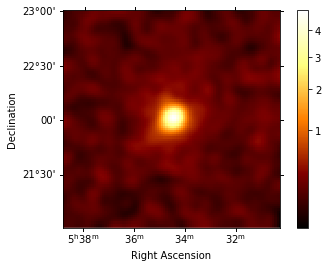

In [16]:
_=stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True
)
# Info: this smoothing does not conserve the number of counts

## Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [17]:
path = Path("analysis_2")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `~gammapy.cube.MapDataset.write()` method:

In [18]:
filename = path / "crab-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [36]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.7,
    amplitude=1.0e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

Now we assign this model to our reduced dataset:

In [37]:
stacked.models = sky_model

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its contructor takes a list of dataset as argument.

In [38]:
%%time
fit = Fit([stacked])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.423E+04               |     Ncalls=234 (234 total)     |
| EDM = 4.91E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 4.17 s, sys: 145 ms, total: 4.32 s
Wall time: 4.32 s


The `FitResult` contains information on the fitted parameters.

In [39]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,8.362e+01,3.135e-03,deg,nan,nan,False
lat_0,2.202e+01,2.938e-03,deg,-9.000e+01,9.000e+01,False
index,2.575e+00,1.038e-01,,nan,nan,False
amplitude,4.632e-11,3.965e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,9.619e-01,2.332e-02,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


### Inspecting residuals

For any fit it is usefull to inspect the residual images. We have a few option on the dataset object to handle this. First we can use `.plot_residuals()` to plot a residual image, summed over all energies: 

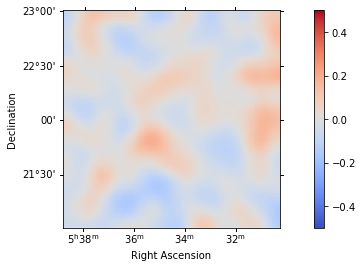

In [40]:
_=stacked.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In addition we can aslo specify a region in the map to show the spectral residuals:

In [41]:
region = CircleSkyRegion(
    center=SkyCoord("83.63 deg", "22.14 deg"), radius=0.5 * u.deg
)

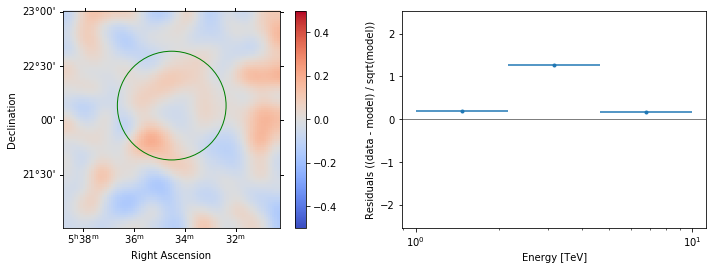

In [42]:
_=stacked.plot_residuals(
    region=region, method="diff/sqrt(model)", vmin=-0.5, vmax=0.5
)

We can also directly access the `.residuals()` to get a map, that we can plot interactively:

In [27]:
residuals = stacked.residuals(method="diff")
residuals.smooth("0.08 deg").plot_interactive(
    cmap="coolwarm", vmin=-0.1, vmax=0.1, stretch="linear", add_cbar=True
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

### Inspecting fit statistic profiles

To check the quality of the fit it is also useful to plot fit statistic profiles for specific parameters.
For this we use `~gammapy.modeling.Fit.stat_profile()`.

In [28]:
profile = fit.stat_profile(parameter="lon_0")

For a good fit and error estimate the profile should be parabolic, if we plot it:

Text(0, 0.5, 'Delta TS')

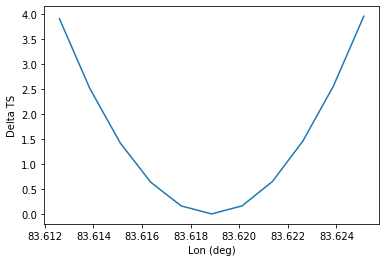

In [29]:
total_stat = result.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel("Lon (deg)")
plt.ylabel("Delta TS")

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the enveloppe of the model taking into account parameter uncertainties.

To do so, we have to copy the part of the covariance matrix stored on the `FitResult` on the model parameters:

In [30]:
spec = sky_model.spectral_model

# set covariance on the spectral model
covar = result.parameters.get_subcovariance(spec.parameters)
spec.parameters.covariance = covar

Now we can actually do the plot using the `plot_error` method:

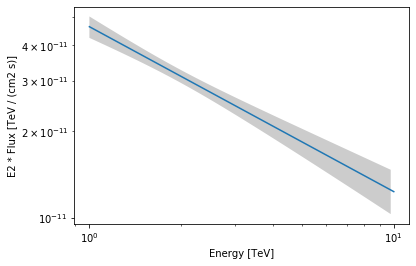

In [31]:
energy_range = [1, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

### Computing flux points

We can now compute some flux points using the `~gammapy.spectrum.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [32]:
e_edges = [1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(datasets=[stacked], e_edges=e_edges, source="crab")

In [33]:
%%time
flux_points = fpe.run()

CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.64 s


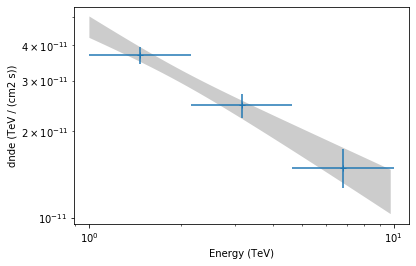

In [35]:
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
_=flux_points.plot(ax=ax, energy_power=2)